# Exercise 2.
# Computing SPECTER Embeddings for Papers

Machine learning and data visualization strategies generally work best on data that is numeric. However, text data is also quite common in various domains. Modern Natural Language Processing (NLP) algorithms powered by machine learning, and trained on massive datasets, can convert text data into numeric vectors. Such algorithms ensure that similar items are represented by similar vectors.

For this task, we will use the SPECTER model to compute embeddings for paper titles and abstracts identified in a previous exercise. The SPECTER model returns a 768-dimensional vector for each text input.

In [1]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pytorch_model.bin: 100%|██████████| 440M/440M [01:46<00:00, 4.15MB/s] 


In [2]:
import json
with open('metadata.json') as f:
    papers = json.load(f)

In [3]:
import tqdm

# we can use a persistent dictionary (via shelve) so we can stop and restart if needed
# alternatively, do the same but with embeddings starting as an empty dictionary
embeddings = {}
for pmid, paper in tqdm.tqdm(papers.items()):
    data = [paper["ArticleTitle"] + tokenizer.sep_token + "".join(paper["AbstractText"])]
    inputs = tokenizer(
        data, padding=True, truncation=True, return_tensors="pt", max_length=512
    )
    result = model(**inputs)
    # take the first token in the batch as the embedding
    embeddings[pmid] = result.last_hidden_state[:, 0, :].detach().numpy()[0]

# turn our dictionary into a list
embeddings = [embeddings[pmid] for pmid in papers.keys()]

100%|██████████| 1994/1994 [32:06<00:00,  1.03it/s]


In [4]:
from sklearn import decomposition
import pandas as pd

pca = decomposition.PCA(n_components=3)
embeddings_pca = pd.DataFrame(
    pca.fit_transform(embeddings),
    columns=['PC0', 'PC1', 'PC2']
)
embeddings_pca["query"] = [paper["query"] for paper in papers.values()]

In [5]:
embeddings_pca

,PC0,PC1,PC2,query
0,-1.499764,3.079033,-2.893260,Alzheimers
1,-5.236744,4.390724,1.171794,Alzheimers
2,-5.105960,-2.530446,-3.978613,Alzheimers
3,-6.976255,-2.731421,-1.645280,Alzheimers
4,-3.770983,-1.909597,1.119820,Alzheimers
...,...,...,...,...
1989,3.519124,-4.601136,1.202660,cancer
1990,2.226133,-2.481808,3.815585,cancer
1991,3.235941,0.327157,-0.078199,cancer
1992,4.228046,-1.301272,0.139682,cancer


In [7]:
import matplotlib.pyplot as plt

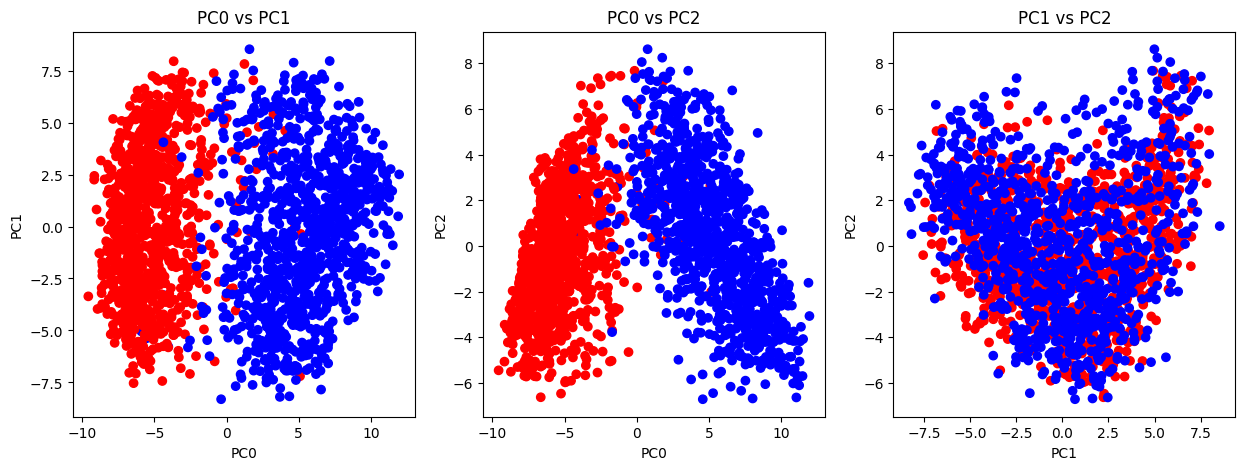

In [8]:
# Plot 2D scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# PC0 vs PC1
axes[0].scatter(embeddings_pca["PC0"], embeddings_pca["PC1"], c=embeddings_pca["query"].map({"Alzheimers": "red", "cancer": "blue"}))
axes[0].set_title('PC0 vs PC1')
axes[0].set_xlabel('PC0')
axes[0].set_ylabel('PC1')

# PC0 vs PC2
axes[1].scatter(embeddings_pca["PC0"], embeddings_pca["PC2"], c=embeddings_pca["query"].map({"Alzheimers": "red", "cancer": "blue"}))
axes[1].set_title('PC0 vs PC2')
axes[1].set_xlabel('PC0')
axes[1].set_ylabel('PC2')

# PC1 vs PC2
axes[2].scatter(embeddings_pca["PC1"], embeddings_pca["PC2"], c=embeddings_pca["query"].map({"Alzheimers": "red", "cancer": "blue"}))
axes[2].set_title('PC1 vs PC2')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')

plt.show()

Observations from the scatter plots:

- **PC0 vs PC1**:
  1. Two distinct clusters are evident, with some overlap.
  2. The red cluster is more elongated along the PC0 axis, while the blue cluster has a broader spread along the PC1 axis.

- **PC0 vs PC2**:
  1. The separation between clusters is less pronounced compared to the PC0 vs PC1 plot.
  2. Both clusters exhibit a vertical spread along the PC2 axis, with the blue cluster being more densely packed.

- **PC1 vs PC2**:
  1. There is significant overlap, making differentiation challenging.
  2. Both red and blue points are interspersed without clear separation.

Overall, PC0 vs PC1 provides the most distinct separation between the two groups, while PC1 vs PC2 offers the least.
